In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
bresults = dict()
infResults = dict()
tta = ['non_tta', 'tta']
models = ['mask2former', 'knet', 'ddrnet', 'pointrend', 'segformer', 'segmenter']
for ta in tta:
    bresults[ta] = dict()
    infResults[ta] = dict()
    for model in models:
        results = np.load(f'./{model}_test_{ta}.npy')
        infResults[ta][model] = results[-1][:-1, :-1]
        bresults[ta][model] = results[:-1]

In [3]:
def toBinConfMat(confMat):
    tp = np.diag(confMat)
    fp = np.sum(confMat, axis=0) - tp
    fn = np.sum(confMat, axis=1) - tp
    tn = np.sum(confMat) - tp - fp - fn
    return tp, fp, fn, tn

In [4]:
bbinResults = dict()
infBinResults = dict()
for ta in tta:
    bbinResults[ta] = dict()
    infBinResults[ta] = dict()
    for model in models:
        bbinResults[ta][model] = []
        for i in range(len(bresults[ta][model])):
            bbinResults[ta][model].append(toBinConfMat(bresults[ta][model][i]))
        infBinResults[ta][model] = toBinConfMat(infResults[ta][model])

In [5]:
df = dict()
metrics = ['iou', 'f1', 'acc', 'prec', 'rec']
for ta in tta:
    df[ta] = dict()
    for metric in metrics:
        if metric == 'acc':
            df[ta][metric] = pd.DataFrame(columns=models, index=['Outside billboards', 'Billboard', 'Goal net', 'Occlusion', 'Mean', 'Overall'])
        else:
            df[ta][metric] = pd.DataFrame(columns=models, index=['Outside billboards', 'Billboard', 'Goal net', 'Occlusion', 'Mean'])
        # infdf[ta][metric] = pd.DataFrame(columns=models)
    for model in models:
        tp, fp, fn, tn = infBinResults[ta][model]
        iou = tp / (tp + fp + fn)
        f1 = 2 * tp / (2 * tp + fp + fn)
        acc = (tp + tn) / (tp + fp + fn + tn)
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        mIoU = np.mean(iou)
        mF1 = np.mean(f1)
        mAcc = np.mean(acc)
        mPrec = np.mean(prec)
        mRec = np.mean(rec)
        # overall accuracy
        infConfMat = infResults[ta][model]
        aAcc = np.trace(infConfMat) / np.sum(infConfMat)
        
        df[ta]['iou'][model] = np.append(iou, mIoU)
        df[ta]['f1'][model] = np.append(f1, mF1)
        df[ta]['acc'][model] = np.concatenate((acc, [mAcc, aAcc]))
        df[ta]['prec'][model] = np.append(prec, mPrec)
        df[ta]['rec'][model] = np.append(rec, mRec)
    for metric in metrics:
        df[ta][metric] *= 100

/tmp/ipykernel_232340/4229935057.py:13: RuntimeWarning: invalid value encountered in divide
  iou = tp / (tp + fp + fn)
/tmp/ipykernel_232340/4229935057.py:14: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * tp / (2 * tp + fp + fn)
/tmp/ipykernel_232340/4229935057.py:15: RuntimeWarning: invalid value encountered in divide
  acc = (tp + tn) / (tp + fp + fn + tn)
/tmp/ipykernel_232340/4229935057.py:16: RuntimeWarning: invalid value encountered in divide
  prec = tp / (tp + fp)
/tmp/ipykernel_232340/4229935057.py:17: RuntimeWarning: invalid value encountered in divide
  rec = tp / (tp + fn)
/tmp/ipykernel_232340/4229935057.py:25: RuntimeWarning: invalid value encountered in scalar divide
  aAcc = np.trace(infConfMat) / np.sum(infConfMat)


In [6]:
with open("Model comparison.txt", "w") as text_file:
    for metric in metrics:
        for ta in tta:
            latex = df[ta][metric].to_latex(float_format="%.2f", position='h', na_rep='-')
            # latex = latex.replace("\\begin{table}[h]", "\\begin{subtable}[h]\n\\centering")
            latex = latex.replace("\\begin{table}[h]", "\\begin{subtable}[h]{\\textwidth}\n\\centering")
            latex = latex.replace("\\end{table}", "\\end{subtable}")
            latex = latex.replace("%", "\\%")
            if ta == 'non_tta':
                nonttaLatex = latex
            else:
                ttaLatex = latex
                
        if metric == 'iou':
            caption = 'Per class and mean Intersection over Union [%] of the models on the test set'
            label = 'tab:iou'
        elif metric == 'f1':
            caption = 'Per class and mean F1 score [%] of the models on the test set'
            label = 'tab:f1'
        elif metric == 'acc':
            caption = 'Per class, mean, and overall Accuracy [%] of the models on the test set'
            label = 'tab:acc'
        elif metric == 'prec':
            caption = 'Per class and mean Precision [%] of the models on the test set'
            label = 'tab:prec'
        elif metric == 'rec':
            caption = 'Per class and mean Recall [%] of the models on the test set'
            label = 'tab:rec'
        caption = caption.replace("%", "\\%")
        caption += ". \\textbf{Above:} without TTA. \\textbf{Below:} with TTA."
    
        # Make a table of 2 subtables
        text_file.write("\\begin{table}[H]\n")
        text_file.write(nonttaLatex)
        text_file.write("\\newline\n")
        text_file.write("\\vspace*{0.1cm}\n")
        text_file.write("\\newline\n")
        text_file.write(ttaLatex)
        text_file.write("\\caption{" + caption + "}\n")
        text_file.write("\\label{" + label + "}\n")
        text_file.write("\\end{table}\n")
        text_file.write("\n")
            
        # text_file.write(latex)
        # # add new line
        # text_file.write("\n")

In [6]:
bConfMatSample = bresults['non_tta']['mask2former'][4]
df = pd.DataFrame(bConfMatSample, columns=['Outside billboards', 'Billboard', 'Goal net', 'Occlusion', 'Boundary mask'], index=['Outside billboards', 'Billboard', 'Goal net', 'Occlusion', 'Boundary mask'])
df.index.name = 'True label'
df.columns.name = 'Predicted label'
# For each integer in df, add a comma after every 3 digits
df = df.applymap(lambda x: "{:,}".format(x) if isinstance(x, int) else x) # type: ignore

with open("Boundary confusion matrix.txt", "w") as text_file:
    caption = 'Boundary confusion matrix at 5 pixels distance of the Mask2Former model on the test set without test-time augmentation'
    label = 'tab:boundaryConfusionMatrixExample'
    latex = df.to_latex(caption=caption, label=label, position='H')
    # Format integers to put a separator every 3 digits. E.g. 1000000 -> 1,000,000
    latex = latex.replace("\\begin{table}[H]", "\\begin{table}[H]\n\\centering")
    # replace nan with -
    latex = latex.replace("NaN", "-")
    text_file.write(latex)
    # add new line
    text_file.write("\n")
df

/tmp/ipykernel_232340/1536743596.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: "{:,}".format(x) if isinstance(x, int) else x) # type: ignore


Predicted label,Outside billboards,Billboard,Goal net,Occlusion,Boundary mask
True label,,,,,
Outside billboards,"9,302,863","393,803","54,051","29,026","1,796,035"
Billboard,"902,424","9,174,463","40,763","85,618","747,502"
Goal net,"197,631","9,647","1,082,629","42,215","448,741"
Occlusion,"532,690","237,782","81,126","946,196","308,673"
Boundary mask,"855,065","1,129,239","387,828","112,235","1,277,469,755"


In [7]:
df = dict()
for ta in tta:
    df[ta] = pd.DataFrame(columns=models, index=[1, 3, 5, 10, 'inf'])
    for model in models:
        for i in [1, 3, 5, 10]:
            tp, fp, fn, tn = bbinResults[ta][model][i-1]
            iou = (tp / (tp + fp + fn))[:-1]
            miou = np.mean(iou)
            df[ta].at[i, model] = miou
        tp, fp, fn, tn = infBinResults[ta][model]
        iou = (tp / (tp + fp + fn))
        miou = np.mean(iou)
        df[ta].at['inf', model] = miou
    df[ta] *= 100
    df[ta].columns.name = 'Distance [px]'
df['non_tta']  # Or df['tta'] for TTA

/tmp/ipykernel_232340/3773921699.py:7: RuntimeWarning: invalid value encountered in divide
  iou = (tp / (tp + fp + fn))[:-1]
/tmp/ipykernel_232340/3773921699.py:11: RuntimeWarning: invalid value encountered in divide
  iou = (tp / (tp + fp + fn))


Distance [px],mask2former,knet,ddrnet,pointrend,segformer,segmenter
1,17.600191,16.085067,15.934721,13.975082,10.724846,2.3506
3,44.173053,40.495166,38.851207,36.977134,32.399516,8.18829
5,56.068264,51.845719,49.590948,48.349821,44.603559,14.799409
10,68.012697,63.542388,60.837744,60.36887,58.483998,28.088372
inf,81.541102,78.738681,75.94281,75.027846,76.814693,55.119621


In [29]:
with open("Boundary mIoU.txt", "w") as text_file:
    for ta in tta:
        caption = 'Boundary mIoU [%] of the models on the test set'
        label = 'tab:boundaryMiou'
        if ta == 'tta':
            caption += ' with test-time augmentation'
            label += '_tta'
        else:
            caption += ' without test-time augmentation'
            label += '_non_tta'
        latex = df[ta].to_latex(float_format="%.2f", caption=caption, label=label, position='H')
        latex = latex.replace("\\begin{table}[H]", "\\begin{table}[H]\n\\centering")
        latex = latex.replace("%", "\\%")
        # replace nan with -
        latex = latex.replace("NaN", "-")
        # replace inf with $\infty$
        latex = latex.replace("inf", "$\\infty$")
        text_file.write(latex)
        # add new line
        text_file.write("\n")

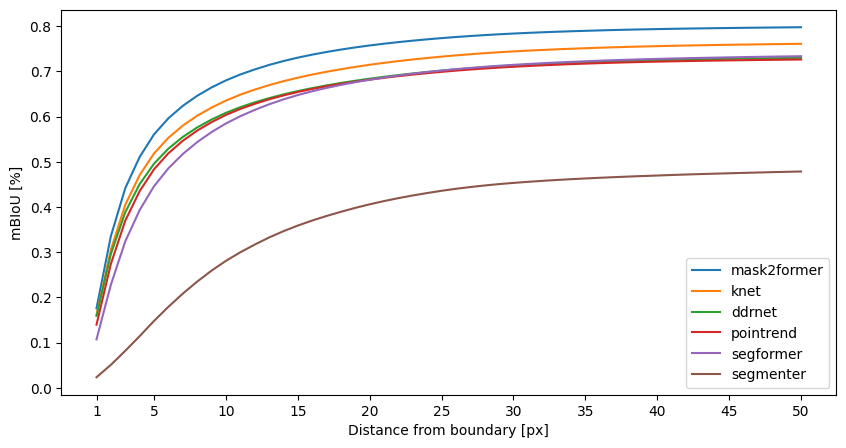

In [30]:
modelsMeanBIoU = np.zeros((50, len(models)))
for i, model in enumerate(models):
    results = bresults['non_tta'][model]
    BIoU = np.zeros((results.shape[0], 4))
    for j, confMat in enumerate(results):
        tp = np.diag(confMat)
        fp = np.sum(confMat, axis=0) - tp
        fn = np.sum(confMat, axis=1) - tp
        BIoU[j] += (tp / (tp + fp + fn))[:4]
    modelsMeanBIoU[:, i] = np.mean(BIoU, axis=1)
maxDist = 50
fig = plt.figure(figsize=(10, 5))
for i in range(len(models)):
    plt.plot(np.arange(1, maxDist+1), modelsMeanBIoU[:maxDist, i])
plt.xlabel('Distance from boundary [px]')
plt.ylabel('mBIoU [%]')
plt.legend(models)
plt.xticks(np.concatenate(([1], np.arange(5, maxDist+1, 5))))
plt.show()
fig.savefig('Boundary mBIoU non_tta.pdf', bbox_inches='tight')

/tmp/ipykernel_26913/847299475.py:9: RuntimeWarning: invalid value encountered in divide
  BIoU[j] += (tp / (tp + fp + fn))[:4]


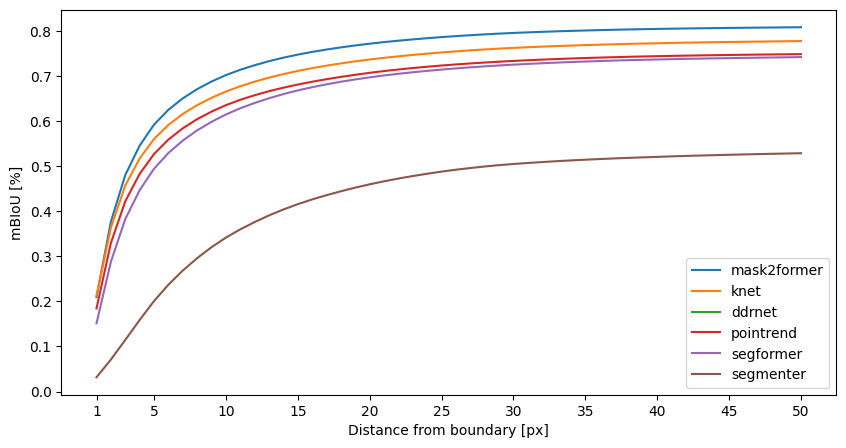

In [31]:
modelsMeanBIoU = np.zeros((50, len(models)))
for i, model in enumerate(models):
    results = bresults['tta'][model]
    BIoU = np.zeros((results.shape[0], 4))
    for j, confMat in enumerate(results):
        tp = np.diag(confMat)
        fp = np.sum(confMat, axis=0) - tp
        fn = np.sum(confMat, axis=1) - tp
        BIoU[j] += (tp / (tp + fp + fn))[:4]
    modelsMeanBIoU[:, i] = np.mean(BIoU, axis=1)
maxDist = 50
fig = plt.figure(figsize=(10, 5))
for i in range(len(models)):
    plt.plot(np.arange(1, maxDist+1), modelsMeanBIoU[:maxDist, i])
plt.xlabel('Distance from boundary [px]')
plt.ylabel('mBIoU [%]')
plt.legend(models)
plt.xticks(np.concatenate(([1], np.arange(5, maxDist+1, 5))))
plt.show()
fig.savefig('Boundary mBIoU tta.pdf', bbox_inches='tight')

In [32]:
df = pd.DataFrame(columns=["non-tta", "tta"], index=[1, 3, 5, 10, 'inf'])
for ta in ['non-tta', 'tta']:
    if ta == 'tta':
        results = np.load('./challenge_mask2former_challenge_tta.npy')
    else:
        results = np.load('./challenge_mask2former_challenge_non_tta.npy')
    confMat = results[-1][:-1, :-1]
    bConfMat = results[:-1]
    for d in [1, 3, 5, 10]:
        tp, fp, fn, tn = toBinConfMat(bConfMat[d-1])
        iou = (tp / (tp + fp + fn))[:-1]
        miou = np.mean(iou)
        df.at[d, ta] = miou
    tp, fp, fn, tn = toBinConfMat(confMat)
    iou = tp / (tp + fp + fn)
    miou = np.mean(iou)
    df.at['inf', ta] = miou
df *= 100
df.columns.name = 'Distance [px]'
with open("Boundary mIoU challenge_mask2former.txt", "w") as text_file:
    caption = 'Boundary mIoU [%] of the Mask2Former model on the challenge set'
    label = 'tab:boundaryMiouChallengeMask2Former'
    latex = df.to_latex(float_format="%.2f", caption=caption, label=label, position='H')
    latex = latex.replace("\\begin{table}[H]", "\\begin{table}[H]\n\\centering")
    latex = latex.replace("%", "\\%")
    # replace nan with -
    latex = latex.replace("NaN", "-")
    # replace inf with $\infty$
    latex = latex.replace("inf", "$\\infty$")
    text_file.write(latex)
    # add new line
    text_file.write("\n")

In [33]:
results = np.load('./challenge_mask2former_challenge_tta.npy')
results = results[:-1]
BIoU = np.zeros((results.shape[0], 4))
for i, confMat in enumerate(results):
    tp = np.diag(confMat)
    fp = np.sum(confMat, axis=0) - tp
    fn = np.sum(confMat, axis=1) - tp
    BIoU[i] += (tp / (tp + fp + fn))[:4]

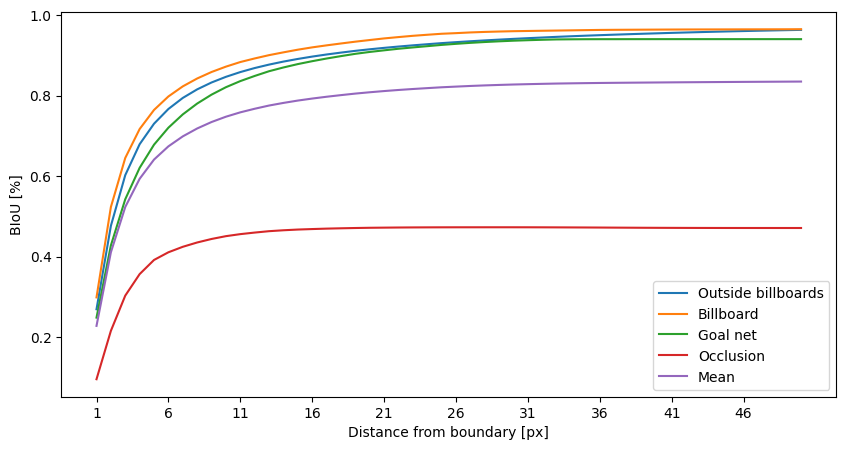

In [34]:
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 50+1), BIoU[:50, 0], label='Outside billboards')
plt.plot(np.arange(1, 50+1), BIoU[:50, 1], label='Billboard')
plt.plot(np.arange(1, 50+1), BIoU[:50, 2], label='Goal net')
plt.plot(np.arange(1, 50+1), BIoU[:50, 3], label='Occlusion')
plt.plot(np.arange(1, 50+1), np.mean(BIoU, axis=1), label='Mean')
plt.xlabel('Distance from boundary [px]')
plt.ylabel('BIoU [%]')
plt.legend()
plt.xticks(np.arange(1, 50+1, 5))
plt.show()
fig.savefig('Boundary Iou challenge_mask2former_tta.pdf', bbox_inches='tight')

In [35]:
results = np.load('./challenge_mask2former_challenge_tta.npy')
confMat = results[-1][:-1, :-1]
bConfMat = results[:-1]

In [36]:
confMat

array([[646854918,    299713,     65020,     55042],
       [   290633,  22513290,      3135,     35283],
       [    33160,      4801,   2647717,     22861],
       [   313001,    174128,     38651,    568647]])

In [37]:
# swap the order of the classes from ['Outside billboards', 'Billboard', 'Goal net', 'Occlusion'] to ['Billboard', 'Goal net', 'Occlusion', 'Outside billboards']
confMat = confMat[[1, 2, 3, 0]][:, [1, 2, 3, 0]]
confMat

array([[ 22513290,      3135,     35283,    290633],
       [     4801,   2647717,     22861,     33160],
       [   174128,     38651,    568647,    313001],
       [   299713,     65020,     55042, 646854918]])

In [38]:
# Let's consider the problem as a two-class problem: Billboard vs. Non-billboard
# The "positive" class is made of the Billboard and Goal net classes while
# the "negative" class is made of the Outside billboards and Occlusion classes
binConfMat = np.zeros((2, 2), dtype=np.int64)
binConfMat[0, 0] = np.sum(confMat[:2, :2]) # TP
binConfMat[0, 1] = np.sum(confMat[:2, 2:]) # FP
binConfMat[1, 0] = np.sum(confMat[2:, :2]) # FN
binConfMat[1, 1] = np.sum(confMat[2:, 2:]) # TN
binConfMat

array([[ 25168943,    381937],
       [   577512, 647791608]])

In [39]:
iou = binConfMat[0, 0] / (binConfMat[0, 0] + binConfMat[0, 1] + binConfMat[1, 0])
iou

np.float64(0.9632794471240327)

In [40]:
bConfMatSample = bConfMat[0]
# print(bConfMatSample)
bConfMatSample = bConfMatSample[[1, 2, 3, 0, 4]][:, [1, 2, 3, 0, 4]]
print(bConfMatSample)

[[   511938      1030     15843    205447    384028]
 [     1896     67332     12370     19935     70934]
 [   131326     17048     59967    163133    173254]
 [   175125     20620      6063    498469    473290]
 [   289239     60295     52975    292029 670216414]]


In [41]:
binBConfMatSample = np.zeros((3, 3), dtype=np.int64)
binBConfMatSample[0, 0] = np.sum(bConfMatSample[:2, :2]) # TP
binBConfMatSample[0, 1] = np.sum(bConfMatSample[:2, 2:4]) # FP
binBConfMatSample[1, 0] = np.sum(bConfMatSample[2:4, :2]) # FN
binBConfMatSample[1, 1] = np.sum(bConfMatSample[2:4, 2:4]) # TN
binBConfMatSample[0, 2] = np.sum(bConfMatSample[:2, 4])
binBConfMatSample[1, 2] = np.sum(bConfMatSample[2:4, 4])
binBConfMatSample[2, 0] = np.sum(bConfMatSample[4, :2])
binBConfMatSample[2, 1] = np.sum(bConfMatSample[4, 2:4])
binBConfMatSample[2, 2] = bConfMatSample[4, 4]
binBConfMatSample

array([[   582196,    253595,    454962],
       [   344119,    727632,    646544],
       [   349534,    345004, 670216414]])

In [42]:
tp = binBConfMatSample[0, 0]
fp = np.sum(binBConfMatSample, axis=0)[0] - tp
fn = np.sum(binBConfMatSample, axis=1)[0] - tp
tn = np.sum(binBConfMatSample) - tp - fp - fn
tp, fp, fn, tn

(np.int64(582196), np.int64(693653), np.int64(708557), np.int64(671935594))

In [43]:
iou = tp / (tp + fp + fn)
iou

np.float64(0.29338552695365766)

In [44]:
df = pd.DataFrame(columns=['non-tta', 'tta'], index=[1,3,5,10,'inf'])
for ta in ['non-tta', 'tta']:
    model = "challenge_mask2former_challenge"
    if ta == 'tta':
        results = np.load('./' + model + '_tta.npy')
    else:
        results = np.load('./' + model + '_non_tta.npy')
    confMat = results[-1][:-1, :-1]
    confMat = confMat[[1, 2, 3, 0]][:, [1, 2, 3, 0]]
    print(confMat)
    bConfMat = results[:-1]
    for d in [1, 3, 5, 10]:
        bConfMatSample = bConfMat[d-1]
        bConfMatSample = bConfMatSample[[1, 2, 3, 0, 4]][:, [1, 2, 3, 0, 4]]
        binBConfMatSample = np.zeros((3, 3), dtype=np.int64)
        binBConfMatSample[0, 0] = np.sum(bConfMatSample[:2, :2]) # TP
        binBConfMatSample[0, 1] = np.sum(bConfMatSample[:2, 2:4]) # FP
        binBConfMatSample[1, 0] = np.sum(bConfMatSample[2:4, :2]) # FN
        binBConfMatSample[1, 1] = np.sum(bConfMatSample[2:4, 2:4]) # TN
        binBConfMatSample[0, 2] = np.sum(bConfMatSample[:2, 4])
        binBConfMatSample[1, 2] = np.sum(bConfMatSample[2:4, 4])
        binBConfMatSample[2, 0] = np.sum(bConfMatSample[4, :2])
        binBConfMatSample[2, 1] = np.sum(bConfMatSample[4, 2:4])
        binBConfMatSample[2, 2] = bConfMatSample[4, 4]
        tp = binBConfMatSample[0, 0]
        fp = np.sum(binBConfMatSample, axis=0)[0] - tp
        fn = np.sum(binBConfMatSample, axis=1)[0] - tp
        tn = np.sum(binBConfMatSample) - tp - fp - fn
        iou = tp / (tp + fp + fn)
        df.at[d, ta] = iou
    binConfMat = np.zeros((2, 2), dtype=np.int64)
    binConfMat[0, 0] = np.sum(confMat[:2, :2]) # TP
    binConfMat[0, 1] = np.sum(confMat[:2, 2:]) # FP
    binConfMat[1, 0] = np.sum(confMat[2:, :2]) # FN
    binConfMat[1, 1] = np.sum(confMat[2:, 2:]) # TN
    print(binConfMat)
    iou = binConfMat[0, 0] / (binConfMat[0, 0] + binConfMat[0, 1] + binConfMat[1, 0])
    df.at['inf', ta] = iou
df *= 100
df.columns.name = 'Distance [px]'
with open("Boundary Iou binary challenge_mask2former.txt", "w") as text_file:
    caption = 'Binary boundary Iou [%] of the Mask2Former model on the challenge set'
    label = 'tab:binaryboundaryIouChallengeMask2Former'
    latex = df.to_latex(float_format="%.2f", caption=caption, label=label, position='H')
    latex = latex.replace("\\begin{table}[H]", "\\begin{table}[H]\n\\centering")
    latex = latex.replace("%", "\\%")
    # replace nan with -
    latex = latex.replace("NaN", "-")
    # replace inf with $\infty$
    latex = latex.replace("inf", "$\\infty$")
    text_file.write(latex)
    # add new line
    text_file.write("\n")

[[ 22391413      7363     47774    395791]
 [     4897   2635929     28417     39296]
 [   178971     48137    546726    320593]
 [   315702     68527     56435 646834029]]
[[ 25039602    511278]
 [   611337 647757783]]
[[ 22513290      3135     35283    290633]
 [     4801   2647717     22861     33160]
 [   174128     38651    568647    313001]
 [   299713     65020     55042 646854918]]
[[ 25168943    381937]
 [   577512 647791608]]


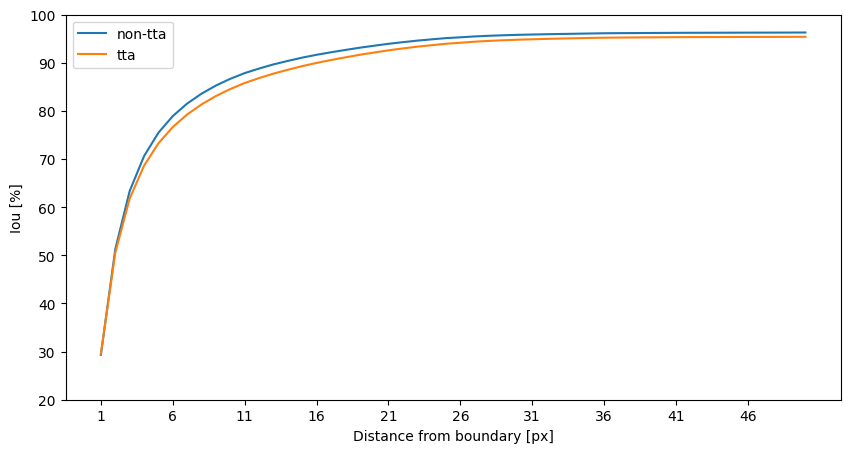

In [50]:
nonttaIou = np.zeros(50)
results = np.load('./challenge_mask2former_challenge_tta.npy')
bConfMat = results[:-1]
for d in range(1,50+1):
    bConfMatSample = bConfMat[d-1]
    bConfMatSample = bConfMatSample[[1, 2, 3, 0, 4]][:, [1, 2, 3, 0, 4]]
    binBConfMatSample = np.zeros((3, 3), dtype=np.int64)
    binBConfMatSample[0, 0] = np.sum(bConfMatSample[:2, :2]) # TP
    binBConfMatSample[0, 1] = np.sum(bConfMatSample[:2, 2:4]) # FP
    binBConfMatSample[1, 0] = np.sum(bConfMatSample[2:4, :2]) # FN
    binBConfMatSample[1, 1] = np.sum(bConfMatSample[2:4, 2:4]) # TN
    binBConfMatSample[0, 2] = np.sum(bConfMatSample[:2, 4])
    binBConfMatSample[1, 2] = np.sum(bConfMatSample[2:4, 4])
    binBConfMatSample[2, 0] = np.sum(bConfMatSample[4, :2])
    binBConfMatSample[2, 1] = np.sum(bConfMatSample[4, 2:4])
    binBConfMatSample[2, 2] = bConfMatSample[4, 4]
    tp = binBConfMatSample[0, 0]
    fp = np.sum(binBConfMatSample, axis=0)[0] - tp
    fn = np.sum(binBConfMatSample, axis=1)[0] - tp
    tn = np.sum(binBConfMatSample) - tp - fp - fn
    iou = tp / (tp + fp + fn)
    nonttaIou[d-1] = iou
ttaIou = np.zeros(50)
# results = np.load('./challenge_mask2former_challenge_tta.npy')
results = np.load('./mask2former_challenge_tta.npy')
bConfMat = results[:-1]
for d in range(1,50+1):
    bConfMatSample = bConfMat[d-1]
    bConfMatSample = bConfMatSample[[1, 2, 3, 0, 4]][:, [1, 2, 3, 0, 4]]
    binBConfMatSample = np.zeros((3, 3), dtype=np.int64)
    binBConfMatSample[0, 0] = np.sum(bConfMatSample[:2, :2]) # TP
    binBConfMatSample[0, 1] = np.sum(bConfMatSample[:2, 2:4]) # FP
    binBConfMatSample[1, 0] = np.sum(bConfMatSample[2:4, :2]) # FN
    binBConfMatSample[1, 1] = np.sum(bConfMatSample[2:4, 2:4]) # TN
    binBConfMatSample[0, 2] = np.sum(bConfMatSample[:2, 4])
    binBConfMatSample[1, 2] = np.sum(bConfMatSample[2:4, 4])
    binBConfMatSample[2, 0] = np.sum(bConfMatSample[4, :2])
    binBConfMatSample[2, 1] = np.sum(bConfMatSample[4, 2:4])
    binBConfMatSample[2, 2] = bConfMatSample[4, 4]
    tp = binBConfMatSample[0, 0]
    fp = np.sum(binBConfMatSample, axis=0)[0] - tp
    fn = np.sum(binBConfMatSample, axis=1)[0] - tp
    tn = np.sum(binBConfMatSample) - tp - fp - fn
    iou = tp / (tp + fp + fn)
    ttaIou[d-1] = iou
nonttaIou *= 100
ttaIou *= 100
fig = plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 50+1), nonttaIou, label='non-tta')
plt.plot(np.arange(1, 50+1), ttaIou, label='tta')
plt.xlabel('Distance from boundary [px]')
plt.ylabel('Iou [%]')
plt.legend()
plt.xticks(np.arange(1, 50+1, 5))
plt.yticks(np.arange(20, 101, 10))
plt.show()
fig.savefig('Binary Boundary Iou challenge_mask2former.pdf', bbox_inches='tight')

In [51]:
print(nonttaIou)
print(ttaIou)

[29.3385527  51.23714742 63.33765291 70.5997479  75.4716351  78.93425134
 81.54205182 83.59359061 85.28432976 86.68177531 87.87062495 88.81337481
 89.6768421  90.40015862 91.08308177 91.67588337 92.19511428 92.67807065
 93.14263236 93.55726193 93.9574818  94.29706491 94.61392524 94.88205335
 95.13680385 95.30373756 95.48722754 95.62401276 95.73069635 95.8215
 95.88514782 95.94463651 95.99984773 96.04828173 96.09995302 96.14537251
 96.170445   96.18804511 96.20342413 96.21960927 96.23492966 96.24624795
 96.25363812 96.25942019 96.26626662 96.27414039 96.27928734 96.28433011
 96.29306366 96.3052743 ]
[29.58156468 50.49205762 61.77062676 68.6120088  73.27192346 76.6603577
 79.27065529 81.35755637 83.10602791 84.55952681 85.8063735  86.8316381
 87.76148658 88.56142136 89.31795822 89.98484599 90.58335476 91.13774908
 91.66916727 92.14260566 92.59825075 92.99492992 93.35581934 93.6697739
 93.96610611 94.17719642 94.39655085 94.5627873  94.69826327 94.80904945
 94.89833542 94.97833234 95.0475